In [ ]:
import os
from glob import glob
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

2025-06-13 14:29:30.270112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749824970.477900      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749824970.535604      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Danh sách cảm xúc từ VNEMOS
EMOTIONS = ['angry', 'happiness', 'anxiety', 'neutral', 'sadness']
NUM_CLASSES = len(EMOTIONS)

# Cần tính toán thực tế từ dữ liệu
GLOBAL_MEAN_PITCH = 0.0
GLOBAL_JITTER = 0.0
GLOBAL_PITCH_SLOPE = 0.0

# Hàm thêm nhiễu
def add_noise(audio, noise_factor=0.01):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

# Hàm thay đổi cao độ
def pitch_shift(audio, sr, n_steps=2): # Random n_steps
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

# Hàm kéo giãn thời gian
def time_stretch(audio, rate=0.95): # Random rate
    return librosa.effects.time_stretch(audio, rate=rate)

# Hàm dịch chuyển thời gian
def time_shift(audio, shift_max=0.2, sr=24200):
    shift = int(np.random.uniform(-shift_max, shift_max) * sr)
    return np.roll(audio, shift)

# Hàm chuẩn hóa cao độ
def normalize_pitch(pitches):
    pitches = pitches[pitches > 0]
    if len(pitches) == 0:
        return GLOBAL_MEAN_PITCH, GLOBAL_JITTER, GLOBAL_PITCH_SLOPE

    mean_pitch = np.mean(pitches)
    normalized_pitches = pitches - mean_pitch
    jitter = np.std(normalized_pitches) if len(normalized_pitches) > 0 else 0

    # Check if there are enough points for polyfit
    if len(pitches) > 1:
        slope = np.polyfit(np.arange(len(pitches)), pitches, 1)[0]
    else:
        slope = 0 # Fallback for single point

    # Handle NaN values that might arise from edge cases
    if np.isnan(mean_pitch): mean_pitch = GLOBAL_MEAN_PITCH
    if np.isnan(jitter): jitter = GLOBAL_JITTER
    if np.isnan(slope): slope = GLOBAL_PITCH_SLOPE

    return mean_pitch, jitter, slope

# Trích xuất đặc trưng
def extract_features(audio_path, sample_rate=24200, duration=10, n_mfcc=26, n_frames=157, augment_type='normal', global_pitch_params=None):
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate)
        target_length = sample_rate * duration

        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]

        if augment_type == 'noise':
            audio = add_noise(audio)
        elif augment_type == 'pitch':
            audio = pitch_shift(audio, sr)
        elif augment_type == 'stretch':
            audio = time_stretch(audio)
        elif augment_type == 'shift':
            audio = time_shift(audio)

        hop_length = target_length // (n_frames - 1)

        # MFCCs + Delta + Delta-Delta
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=2048)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)

        # Pad or truncate MFCCs
        if mfcc_features.shape[1] > n_frames:
            mfcc_features = mfcc_features[:, :n_frames]
        elif mfcc_features.shape[1] < n_frames:
            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, n_frames - mfcc_features.shape[1])), mode='constant')

        # Pitch features
        pitches, magnitudes = librosa.piptrack(y=audio, sr=sr, hop_length=hop_length)
        if global_pitch_params:
            mean_pitch, jitter, pitch_slope = normalize_pitch(pitches)
            # If normalize_pitch returns fallback values (0,0,0), use global defaults
            if mean_pitch == 0 and jitter == 0 and pitch_slope == 0:
                mean_pitch, jitter, pitch_slope = global_pitch_params
        else:
            mean_pitch, jitter, pitch_slope = normalize_pitch(pitches) # Will use current GLOBAL_*

        pitch_features_single = np.array([mean_pitch, jitter, pitch_slope])
        pitch_features = np.tile(pitch_features_single, (n_frames, 1)).T # Tile to match n_frames

        # Energy features (RMS + mean and std)
        energy = librosa.feature.rms(y=audio, hop_length=hop_length)[0]
        if len(energy) > n_frames:
            energy = energy[:n_frames]
        elif len(energy) < n_frames:
            energy = np.pad(energy, (0, n_frames - len(energy)), mode='constant')

        mean_energy = np.mean(energy)
        shimmer = np.std(energy) if len(energy) > 0 else 0
        energy_features = np.array([energy, np.full(n_frames, mean_energy), np.full(n_frames, shimmer)])

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length)[0]
        if len(zcr) > n_frames:
            zcr = zcr[:n_frames]
        elif len(zcr) < n_frames:
            zcr = np.pad(zcr, (0, n_frames - len(zcr)), mode='constant')
        zcr_features = zcr[np.newaxis, :]

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=hop_length, n_chroma=12)
        if chroma.shape[1] > n_frames:
            chroma = chroma[:, :n_frames]
        elif chroma.shape[1] < n_frames:
            chroma = np.pad(chroma, ((0, 0), (0, n_frames - chroma.shape[1])), mode='constant')

        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=hop_length)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=hop_length)[0]
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, hop_length=hop_length, n_bands=5)

        # Pad or truncate spectral features
        # Assuming all spectral features have the same number of frames
        if spectral_centroid.shape[0] > n_frames:
            spectral_centroid = spectral_centroid[:n_frames]
            spectral_rolloff = spectral_rolloff[:n_frames]
            spectral_contrast = spectral_contrast[:, :n_frames]
        elif spectral_centroid.shape[0] < n_frames:
            spectral_centroid = np.pad(spectral_centroid, (0, n_frames - spectral_centroid.shape[0]), mode='constant')
            spectral_rolloff = np.pad(spectral_rolloff, (0, n_frames - spectral_rolloff.shape[0]), mode='constant')
            spectral_contrast = np.pad(spectral_contrast, ((0, 0), (0, n_frames - spectral_contrast.shape[1])), mode='constant')
        spectral_features = np.vstack([spectral_centroid, spectral_rolloff, spectral_contrast])

        # Temporal features
        voiced_frames = librosa.effects.split(audio, top_db=20)
        speech_rate = len(voiced_frames) / (duration if duration > 0 else 1)
        pauses = len(voiced_frames) - 1 if len(voiced_frames) > 1 else 0
        temporal_features_single = np.array([speech_rate, pauses])
        temporal_features = np.tile(temporal_features_single, (n_frames, 1)).T

        features = np.concatenate([
            mfcc_features, # Now includes delta and delta-delta
            pitch_features,
            energy_features,
            zcr_features,
            chroma,
            spectral_features,
            temporal_features
        ], axis=0)

        return np.expand_dims(features, axis=-1)

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Xây dựng mô hình CNN cải tiến
def build_cnn_2d(input_shape=(55, 157, 1)): # input_shape sẽ thay đổi nếu thêm delta/delta-delta
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.4),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.summary()
    return model

# Thêm hàm để tính toán GLOBAL_PITCH_PARAMS
def calculate_global_pitch_params(audio_files, sample_rate=24200):
    all_pitches = []
    for audio_path in audio_files:
        try:
            audio, sr = librosa.load(audio_path, sr=sample_rate)
            pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
            pitches = pitches[pitches > 0]
            if len(pitches) > 0:
                all_pitches.extend(pitches)
        except Exception as e:
            print(f"Error calculating global pitch for {audio_path}: {e}")
            continue

    if len(all_pitches) == 0:
        print("Warning: No valid pitches found to calculate global parameters. Using default zeros.")
        return 0.0, 0.0, 0.0

    all_pitches = np.array(all_pitches)
    global_mean_pitch = np.mean(all_pitches)

    normalized_all_pitches = all_pitches - global_mean_pitch
    global_jitter = np.std(normalized_all_pitches) if len(normalized_all_pitches) > 0 else 0

    # Calculate global pitch slope (simple average of local slopes, or fit a line to all pitches)
    # For simplicity, let's use the average of slopes calculated over reasonable segments
    # A more robust approach might involve fitting a trend line to all valid pitch values,
    # but that's computationally intensive. For global, a simple average might suffice or set to 0.
    global_pitch_slope = 0.0 # Often jitter is more informative than overall slope for global

    # Consider replacing NaN/inf with 0 in case of edge issues
    global_mean_pitch = 0.0 if np.isnan(global_mean_pitch) or np.isinf(global_mean_pitch) else global_mean_pitch
    global_jitter = 0.0 if np.isnan(global_jitter) or np.isinf(global_jitter) else global_jitter
    global_pitch_slope = 0.0 if np.isnan(global_pitch_slope) or np.isinf(global_pitch_slope) else global_pitch_slope

    return global_mean_pitch, global_jitter, global_pitch_slope


# Hàm chuẩn bị dữ liệu với ánh xạ nhãn từ thư mục
def prepare_training_data(audio_files, emotion_map, global_pitch_params):
    X, y = [], []
    augment_types = ['normal', 'noise', 'pitch', 'stretch', 'shift']
    skipped_files = 0
    processed_files = 0

    print(f"Tổng số file âm thanh: {len(audio_files)}")
    for audio_path in audio_files:
        folder_name = os.path.basename(os.path.dirname(audio_path))
        if folder_name not in emotion_map:
            # print(f"Warning: {audio_path} có folder không hợp lệ ({folder_name}), bỏ qua.")
            skipped_files += 1
            continue
        emotion_idx = emotion_map[folder_name]

        for aug_type in augment_types:
            features = extract_features(str(audio_path), augment_type=aug_type, global_pitch_params=global_pitch_params)
            if features is None or np.all(features == 0):
                # print(f"Warning: Không thể trích xuất đặc trưng từ {audio_path} (aug_type: {aug_type})")
                continue
            X.append(features)
            y.append(emotion_idx)
            processed_files += 1

    print(f"Đã xử lý: {processed_files} mẫu, bỏ qua: {skipped_files} file.")
    if not X or not y:
        raise ValueError("Không có file âm thanh nào được xử lý thành công. Kiểm tra đường dẫn dữ liệu hoặc emotion_map.")

    X = np.array(X)
    y = to_categorical(y, num_classes=NUM_CLASSES)
    print(f"Dataset shape: X={X.shape}, y={y.shape}")
    return X, y

# Hàm chuẩn bị dữ liệu kiểm tra (test)
def prepare_test_data(audio_files, emotion_map, global_pitch_params):
    X, y = [], []
    skipped_files = 0
    processed_files = 0

    print(f"Tổng số file âm thanh kiểm tra: {len(audio_files)}")
    for audio_path in audio_files:
        folder_name = os.path.basename(os.path.dirname(audio_path))
        if folder_name not in emotion_map:
            # print(f"Warning: {audio_path} có folder không hợp lệ ({folder_name}), bỏ qua.")
            skipped_files += 1
            continue
        emotion_idx = emotion_map[folder_name]
        features = extract_features(str(audio_path), augment_type='normal', global_pitch_params=global_pitch_params)
        if features is None or np.all(features == 0):
            # print(f"Warning: Không thể trích xuất đặc trưng từ {audio_path}")
            continue
        X.append(features)
        y.append(emotion_idx)
        processed_files += 1

    print(f"Đã xử lý: {processed_files} mẫu, bỏ qua: {skipped_files} file.")
    if not X or not y:
        raise ValueError("Không có file âm thanh kiểm tra nào được xử lý thành công.")

    X = np.array(X)
    y = to_categorical(y, num_classes=NUM_CLASSES)
    print(f"Test dataset shape: X={X.shape}, y={y.shape}")
    return X, y

# Đánh giá mô hình với ma trận nhầm lẫn và F1 Score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Print sample probabilities for debugging
    print("\nSample prediction probabilities:")
    for i in range(min(5, len(X_test))):
        print(f"Sample {i+1}: True={EMOTIONS[y_true_classes[i]]}, Pred={EMOTIONS[y_pred_classes[i]]}, Prob={y_pred[i]}")

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns_heatmap  = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=EMOTIONS))

    print("\nCông thức các số liệu đánh giá:")
    print("1. Precision = TP / (TP + FP)")
    print("   - TP (True Positives): Số mẫu dự đoán đúng cho một lớp.")
    print("   - FP (False Positives): Số mẫu dự đoán sai là lớp đó.")
    print("2. Recall = TP / (TP + FN)")
    print("   - FN (False Negatives): Số mẫu thuộc lớp đó nhưng dự đoán sai.")
    print("3. F1 Score = 2 * (Precision * Recall) / (Precision + Recall)")

# Huấn luyện và đánh giá
def train_and_evaluate_model(model, X, y, epochs=200, batch_size=16, checkpoint_path='best_model.h5', class_weight=None):
    if len(X) == 0 or len(y) == 0:
        raise ValueError("Tập dữ liệu huấn luyện rỗng. Kiểm tra dữ liệu đầu vào.")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        class_weight=class_weight,
                        verbose=1)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"\nĐánh giá trên tập kiểm tra:")
    print(f" - Loss: {val_loss:.4f}")
    print(f" - Accuracy: {val_accuracy:.4f}")
    return model, history, X_val, y_val

# Dự đoán trực tiếp bằng CNN
def predict_emotion(audio_path, model, scaler, global_pitch_params):
    features = extract_features(audio_path, augment_type='normal', global_pitch_params=global_pitch_params)
    if features is None or np.all(features == 0):
        return "Không thể dự đoán: Lỗi trích xuất đặc trưng."

    # Reshape features for scaling
    features_2d = features.reshape(1, -1)
    features_2d = scaler.transform(features_2d)  # Apply scaler
    features = features_2d.reshape(features.shape)

    features = np.expand_dims(features, axis=0)
    prediction = model.predict(features, verbose=0)
    predicted_emotion_idx = np.argmax(prediction, axis=1)[0]

    # Print probabilities for debugging
    print(f"Prediction probabilities for {audio_path}: {prediction[0]}")
    return EMOTIONS[predicted_emotion_idx]

# Vẽ biểu đồ Loss
def plot_loss_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Found 144 files in folder: angry
Found 164 files in folder: neutral
Found 109 files in folder: anxiety
Found 140 files in folder: sadness
Found 115 files in folder: happiness
Calculating GLOBAL_PITCH_PARAMS from training data...
GLOBAL_MEAN_PITCH: 1316.5161, GLOBAL_JITTER: 1039.6665, GLOBAL_PITCH_SLOPE: 0.0000
Phân bố nhãn gốc: Counter({'neutral': 164, 'angry': 144, 'sadness': 140, 'happiness': 115, 'anxiety': 109})
Class weights: {0: 0.9333333333333333, 1: 1.1686956521739131, 2: 1.2330275229357799, 3: 0.8195121951219512, 4: 0.96}
Tổng số file âm thanh: 672
Đã xử lý: 3360 mẫu, bỏ qua: 0 file.
Dataset shape: X=(3360, 107, 157, 1), y=(3360, 5)
X shape: (3360, 107, 157, 1)
Calculated CNN Input Shape: (107, 157, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 107, 157, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 107, 157, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 53, 78, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 53, 78, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 53, 78, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 53, 78, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 26, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 26, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 26, 39, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 26, 39, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 13, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 13, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 31616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       8,093,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,188,805 (31.24 MB)

 Trainable params: 8,188,357 (31.24 MB)

 Non-trainable params: 448 (1.75 KB)

Train shape: (2688, 107, 157, 1), Val shape: (672, 107, 157, 1)
Epoch 1/100
163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3099 - loss: 3.7561
Epoch 1: val_loss improved from inf to 2.78357, saving model to best_cnn_2d_vesc.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3111 - loss: 3.7216 - val_accuracy: 0.4137 - val_loss: 2.7836 - learning_rate: 1.0000e-04
Epoch 2/100
163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4255 - loss: 2.0874
Epoch 2: val_loss improved from 2.78357 to 2.40725, saving model to best_cnn_2d_vesc.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4262 - loss: 2.0869 - val_accuracy: 0.5104 - val_loss: 2.4073 - learning_rate: 1.0000e-04
Epoch 3/100
163/168 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5006 - loss: 1.9866
Epoch 3: val_loss improved from 2.40725 to 1.96110, saving model to best_cnn_2d_vesc.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5007 - loss: 1.9861 - val_accuracy: 0.5967 - val_loss: 1.

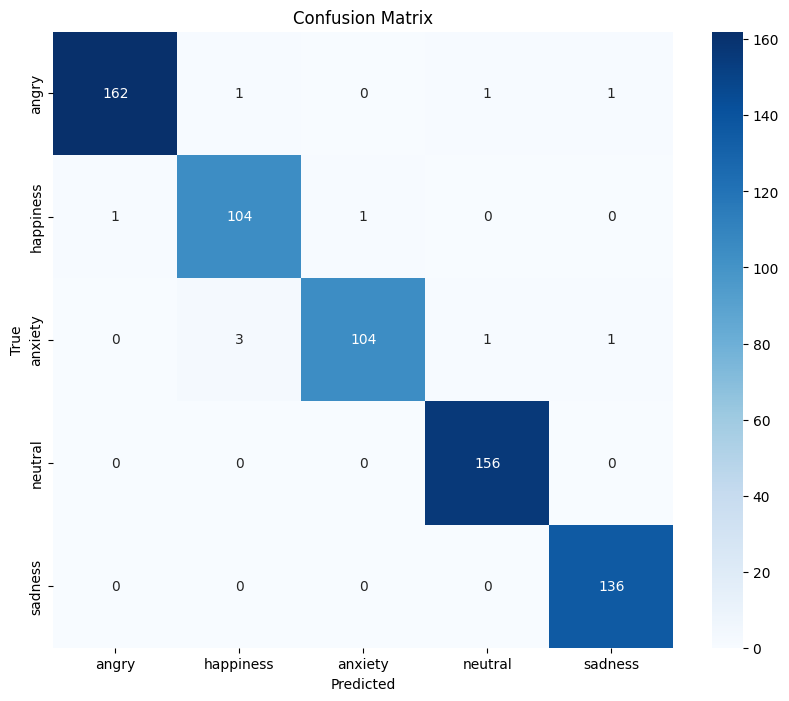


Classification Report:
              precision    recall  f1-score   support

       angry       0.99      0.98      0.99       165
   happiness       0.96      0.98      0.97       106
     anxiety       0.99      0.95      0.97       109
     neutral       0.99      1.00      0.99       156
     sadness       0.99      1.00      0.99       136

    accuracy                           0.99       672
   macro avg       0.98      0.98      0.98       672
weighted avg       0.99      0.99      0.99       672


Công thức các số liệu đánh giá:
1. Precision = TP / (TP + FP)
   - TP (True Positives): Số mẫu dự đoán đúng cho một lớp.
   - FP (False Positives): Số mẫu dự đoán sai là lớp đó.
2. Recall = TP / (TP + FN)
   - FN (False Negatives): Số mẫu thuộc lớp đó nhưng dự đoán sai.
3. F1 Score = 2 * (Precision * Recall) / (Precision + Recall)


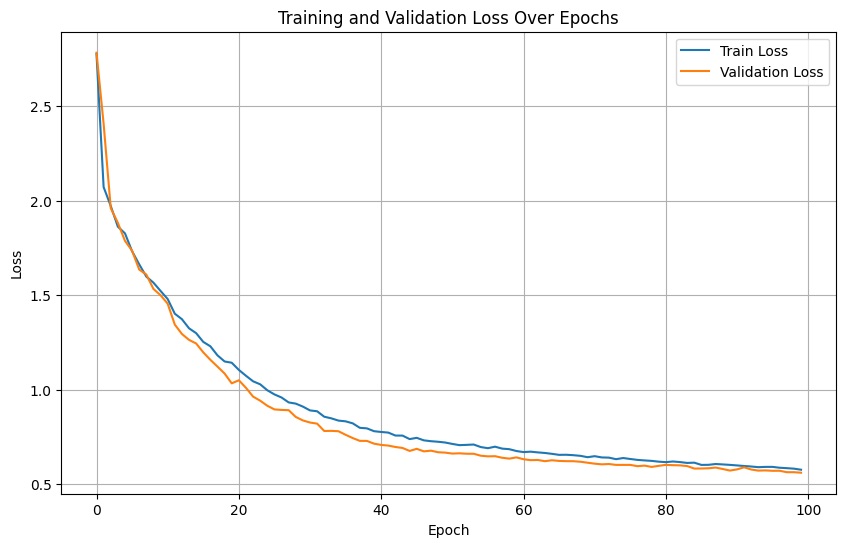

In [ ]:
if __name__ == "__main__":
    # Đường dẫn tới dữ liệu
    root_folder = '/kaggle/input/emotion-8/emotion_vi_train/emotion_vi_train'
    folders = [f for f in glob(os.path.join(root_folder, "*")) if os.path.isdir(f)]
    all_files = []
    for folder in folders:
        files = glob(os.path.join(folder, "**", "*.wav"), recursive=True)
        all_files.extend(files)
        print(f"Found {len(files)} files in folder: {os.path.basename(folder)}")

    if not all_files:
        raise ValueError("Không tìm thấy file âm thanh nào trong thư mục huấn luyện.")

    # Tính toán GLOBAL_PITCH_PARAMS trước
    print("Calculating GLOBAL_PITCH_PARAMS from training data...")
    GLOBAL_MEAN_PITCH, GLOBAL_JITTER, GLOBAL_PITCH_SLOPE = calculate_global_pitch_params(all_files)
    print(f"GLOBAL_MEAN_PITCH: {GLOBAL_MEAN_PITCH:.4f}, GLOBAL_JITTER: {GLOBAL_JITTER:.4f}, GLOBAL_PITCH_SLOPE: {GLOBAL_PITCH_SLOPE:.4f}")

    # Kiểm tra phân bố nhãn
    emotion_map = {
        'angry': 0,
        'happiness': 1,
        'anxiety': 2,
        'neutral': 3,
        'sadness': 4
    }
    y_raw = [emotion_map.get(os.path.basename(os.path.dirname(f)), -1) for f in all_files]
    print("Phân bố nhãn gốc:", Counter([EMOTIONS[i] for i in y_raw if i != -1]))

    # Compute class weights
    y_raw_train = [y for y in y_raw if y != -1]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_raw_train), y=y_raw_train)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)

    # Chuẩn bị dữ liệu
    X, y = prepare_training_data(all_files, emotion_map,(GLOBAL_MEAN_PITCH, GLOBAL_JITTER, GLOBAL_PITCH_SLOPE))
    print(f"X shape: {X.shape}")

    # Chuẩn hóa đặc trưng
    scaler = StandardScaler()
    # Reshape cho scaler (2D)
    original_shape = X.shape
    X_2d = X.reshape(original_shape[0], -1)
    X_2d = scaler.fit_transform(X_2d)
    X = X_2d.reshape(original_shape) # Reshape về lại shape cũ


    calculated_input_dim0 = X.shape[1] # Lấy từ shape của X sau khi trích xuất
    cnn_input_shape = (calculated_input_dim0, X.shape[2], 1)
    print(f"Calculated CNN Input Shape: {cnn_input_shape}")

    # Xây dựng và huấn luyện mô hình
    cnn_model = build_cnn_2d(input_shape = cnn_input_shape)
    cnn_model, history, X_test, y_test = train_and_evaluate_model(
        cnn_model, X, y,
        epochs=100,
        batch_size=16,
        checkpoint_path='best_cnn_2d_vesc.keras',
        class_weight=class_weight_dict
    )

    # Lưu mô hình cuối cùng
    cnn_model.save('final_cnn_2d_vesc.keras')
    evaluate_model(cnn_model, X_test, y_test)
    plot_loss_history(history)

Found 37 files in folder: angry
Found 32 files in folder: neutral
Found 34 files in folder: anxiety
Found 103 files in folder: sadness
Found 50 files in folder: happiness
Total test files: 256
Phân bố nhãn gốc (test): Counter({'sadness': 103, 'happiness': 50, 'angry': 37, 'anxiety': 34, 'neutral': 32})
GLOBAL_MEAN_PITCH: 1316.5161, GLOBAL_JITTER: 1039.6665, GLOBAL_PITCH_SLOPE: 0.0000
Tổng số file âm thanh kiểm tra: 256
Đã xử lý: 256 mẫu, bỏ qua: 0 file.
Test dataset shape: X=(256, 107, 157, 1), y=(256, 5)

Sample prediction probabilities:
Sample 1: True=angry, Pred=angry, Prob=[0.83101237 0.02840387 0.03664352 0.05658088 0.04735928]
Sample 2: True=angry, Pred=angry, Prob=[0.8733665  0.03954218 0.02919557 0.02981634 0.02807949]
Sample 3: True=angry, Pred=angry, Prob=[0.8028269  0.04438223 0.052315   0.04278279 0.05769307]
Sample 4: True=angry, Pred=angry, Prob=[0.67143273 0.03569991 0.1300231  0.03529035 0.12755395]
Sample 5: True=angry, Pred=angry, Prob=[0.7994993  0.03610739 0.0596091

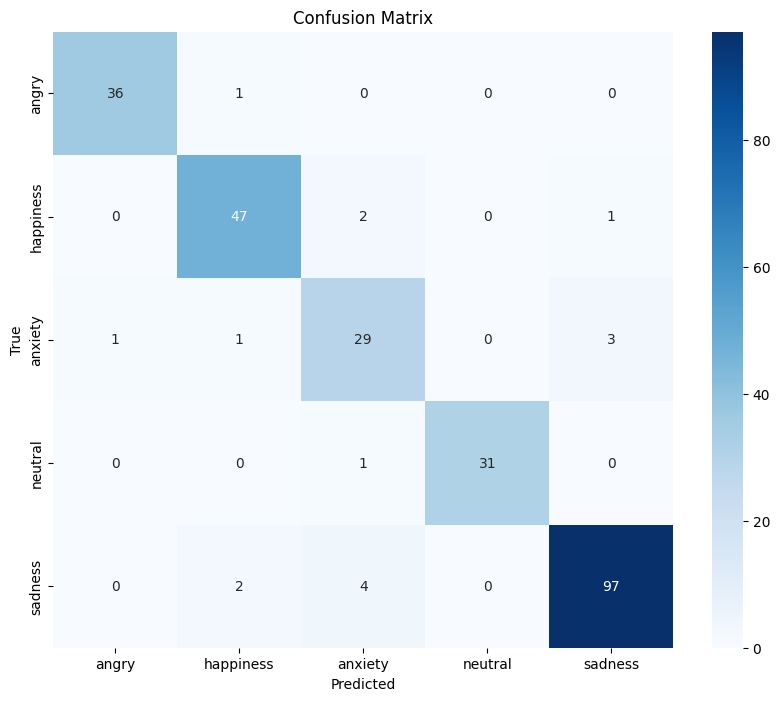


Classification Report:
              precision    recall  f1-score   support

       angry       0.97      0.97      0.97        37
   happiness       0.92      0.94      0.93        50
     anxiety       0.81      0.85      0.83        34
     neutral       1.00      0.97      0.98        32
     sadness       0.96      0.94      0.95       103

    accuracy                           0.94       256
   macro avg       0.93      0.94      0.93       256
weighted avg       0.94      0.94      0.94       256


Công thức các số liệu đánh giá:
1. Precision = TP / (TP + FP)
   - TP (True Positives): Số mẫu dự đoán đúng cho một lớp.
   - FP (False Positives): Số mẫu dự đoán sai là lớp đó.
2. Recall = TP / (TP + FN)
   - FN (False Negatives): Số mẫu thuộc lớp đó nhưng dự đoán sai.
3. F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

Dự đoán trên các file kiểm tra:
Prediction probabilities for /kaggle/input/emotion-8/emotion_vi_test/emotion_vi_test/angry/angry_caytaonohoa_4754_4756.w

In [ ]:
    # Tải mô hình tốt nhất
    best_model = tf.keras.models.load_model('best_cnn_2d_vesc.keras')
    best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                       metrics=['accuracy'])

    # Chuẩn bị dữ liệu kiểm tra
    root_folder_test = "/kaggle/input/emotion-8/emotion_vi_test/emotion_vi_test"
    folders_test = [f for f in glob(os.path.join(root_folder_test, "*")) if os.path.isdir(f)]
    all_files_test = []
    for folder in folders_test:
        files = glob(os.path.join(folder, "**", "*.wav"), recursive=True)
        all_files_test.extend(files)
        print(f"Found {len(files)} files in folder: {os.path.basename(folder)}")

    if not all_files_test:
        raise ValueError("Không tìm thấy file âm thanh nào trong thư mục kiểm tra.")

    print(f"Total test files: {len(all_files_test)}")

    y_raw_test = [emotion_map.get(os.path.basename(os.path.dirname(f)), -1) for f in all_files_test]
    print("Phân bố nhãn gốc (test):", Counter([EMOTIONS[i] for i in y_raw_test if i != -1]))
    print(f"GLOBAL_MEAN_PITCH: {GLOBAL_MEAN_PITCH:.4f}, GLOBAL_JITTER: {GLOBAL_JITTER:.4f}, GLOBAL_PITCH_SLOPE: {GLOBAL_PITCH_SLOPE:.4f}")
    X_test, y_test = prepare_test_data(all_files_test, emotion_map, (GLOBAL_MEAN_PITCH, GLOBAL_JITTER, GLOBAL_PITCH_SLOPE))

    # Chuẩn hóa đặc trưng cho tập kiểm tra
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    X_test_2d = scaler.transform(X_test_2d)
    X_test = X_test_2d.reshape(X_test.shape)

    evaluate_model(best_model, X_test, y_test)

    print("\nDự đoán trên các file kiểm tra:")
    for test_path in all_files_test:
        predicted_emotion = predict_emotion(test_path, best_model, scaler, (GLOBAL_MEAN_PITCH, GLOBAL_JITTER, GLOBAL_PITCH_SLOPE))
        print(f"Dự đoán cảm xúc {os.path.basename(test_path)} (best model): {predicted_emotion}")